In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [13]:
# Task 01
# 1.a: load data frame from file, store into df
df = pd.read_csv('KNNAlgorithmDataset.csv')
#print(df)

#1.c: shuffle the samples
df = df.sample(frac=1)
# frac = [0,1], incase frac = 0.5, shuffle 50% of the rows
#print(df)

# convert data frame into array
data_array = df.values[:, 1:]  #unselect 1st column / label y

# 1.b: set column 'diagnosis' as target variable y / the label
y = df["diagnosis"].values
#print(y) 

In [14]:
# show normalization
#mean = data_array.mean(axis=0)
#standard_deviation = data_array.std(axis=0)
#normalized_data = (data_array - mean) / standard_deviation

#print(normalized_data)

In [15]:
# Task 02: seperate data into training(70%), validation(20%) and test(10%) sets by slicing
da_len = len(data_array)   #number of rows / length of data_array

training_set = data_array[0:int(da_len * 0.7)]
training_label = y[:int(da_len * 0.7)]
#print(training_set.shape)

#print(training_set)
validation_set = data_array[int(da_len * 0.7): int(da_len * 0.9)]
validation_label = y[int(da_len * 0.7): int(da_len * 0.9)]

test_set = data_array[int(da_len* 0.9):]
test_label = y[int(da_len* 0.9):]
#print(len(training_set) + len(validation_set) + len(test_set) == da_len) # the whole data array included in the 3 sets: True 

In [16]:
# 3.c distance algorithms with input of two 1D-Vectors, return distance (real number) of 2 vectors(x1,...,xn)
# Manhattan distance
def manhattan_distance(vector01, vector02):
    # raise error if data points are not of the same length
    if (vector01.shape != vector02.shape):
        raise ValueError("Unequal length of inputed data points")
    # return sum(\xi_m - xj_m\)
    return np.sum(np.abs(vector01 - vector02))    # np.abs(): absolute value of each elements
    # a variante: use np.fabs(v1, v2), return np.sum(np.fabs(vector01 - vector02))

# Euclidean distance
def euclidean_distance(vector01, vector02):
    if (vector01.shape != vector02.shape):
        raise ValueError("Unequal length of inputed data points")
    # use np library: calculate the norm of the new vector (difference of two old vectors)
    return np.linalg.norm(vector01 - vector02)

# Chebyshev distance
def chebyshev_distance(vector01, vector02):
    if (vector01.shape != vector02.shape):
        raise ValueError("Unequal length of inputed data points")
    # return max(\xi_01 - xi_02\)
    absolute_array = [np.abs(vector01[i] - vector02[i]) for i in range(len(vector01))]
    return max(absolute_array)


# test algo with data: 
#t_p01 = training_set[0]
#t_p02 = training_set[1]
#t_short01 = [1.1,2,4.43,8]
#t_short02 = [3,4.7,6,9.69]

#print(manhattan_distance(t_p01, t_p02))    # test (compared with result by online calculator): True
#print(euclidean_distance(t_p01, t_p02))    # definition from numpy library
#print(chebyshev_distance(t_short01, t_short02))    # test: True

In [17]:
# task 3.2: check if user inputs are valid
def check_predictor_input(k, d):
    valid_dist_algos = ['manhattan', 'euclidean', 'chebyshev']
    # there are k training set rows / neighbours for the new data point
    if not isinstance(k, int):
        raise TypeError(f"k should be an integer, given{type(k)}")
    # value of k is too small / large
    if k < 0 or k > len(training_set):
        raise ValueError(f"Value of k should be between 0 and {len(training_set)}")
    # typos of the distance funcs
    if d.lower() not in valid_dist_algos:
        raise ValueError(f"Given algorithm is not valid, please choose from {valid_dist_algos}!")
    
#check_predictor_input("hello", "manhattan")
#check_predictor_input(3, "manha")
#check_predictor_input(-1000000, "euclidean")

In [18]:
# Task 3: implement the kNN algorithm
# accroding to 2.2 kNN algo is capsuled in a kNN predictor
class kNN_predictor:
    #constructor: define attribiutes
    def __init__(self, k, distance_func):    #q: if the k and dist-func is given as param in constructor or later in predict func?
        check_predictor_input(k, distance_func)
        self.trained = False   #default: not trained
        self.k = k  # k neighbours
        if (distance_func == 'manhattan'):
            self.dname = 'Manhattan distance'
            self.d = manhattan_distance
        elif (distance_func == 'euclidean'):
            self.dname = 'Euclidean distance'
            self.d = euclidean_distance
        elif (distance_func == 'chebyshev'):
            self.dname = 'Chebyshev distance'
            self.d = chebyshev_distance
        else:
            raise ValueError("Invalid function")
        # X(data set) and Y(classes / target values) will be provided in fit() as parameters
        self.X = None
        self.Y = None
        # for the normalization
        self.mean = None
        
        self.std = None
    
    def normalize(self, X):
        if self.trained == False:
            raise("Predictor is not trained! Train it first by calling fit()!")
        return (X - self.mean) / self.std
    
    # functions
    def fit(self, training_X, training_Y):
        # feed the model with training data
        self.X = training_X
        self.Y = training_Y
        self.mean = self.X.mean(axis=0)
        self.std = self.X.std(axis=0)
        self.trained = True   #set trained
        # normalize X before storing
        self.X = self.normalize(self.X)
        

    def predict(self, X, thresh=0.5):
        # check if predictor is trained
        if self.trained == False:
            raise("Predictor is not trained! Train it first by calling fit()!")
        
        # call normalize() to normalize the data
        X = self.normalize(X)
        # calculate the distance with all the neighbours
        kNN = []
        for x1 in X:
            dists = []
            for x2 in self.X:
                dist = self.d(x1, x2)
                dists.append(dist)
            nearest_indexes = np.argsort(dists)
            nearest_labels = self.Y[nearest_indexes]
            prob = np.mean(nearest_labels[1:self.k+1])
            kNN.append(prob)
        return np.array(kNN) > thresh

    def confusionMatrix(self, X, Y): 
        #compute confusion matrix, input: X (user input), Y (label)
        X = np.array(X)
        Y = np.array(Y)
        pY = np.array(self.predict(X))
        size = len(X)
        # calculate entries of the confusion matrix by counting entries where the corresponding condition is given and make it relative to the whole set
        TP = len(np.where((Y == 1) & (pY == 1))[0])/size
        TN = len(np.where((Y == 0) & (pY == 0))[0])/size
        FP = len(np.where((Y == 0) & (pY == 1))[0])/size
        FN = len(np.where((Y == 1) & (pY == 0))[0])/size
        return [[TP, FN], [FP, TN]]
  

In [19]:
# Task 4: test the data with user inputs
def test_with_validation(k, func_name):
    predictor_task04 = kNN_predictor(k, func_name)
    predictor_task04.fit(training_set, training_label)
    prediction_result = predictor_task04.predict(validation_set)
    to_be_compare = zip(prediction_result, validation_label)
    accuracy = 0
    for pred, label in to_be_compare:
        if pred == label:
            accuracy += 1
    accuracy = accuracy / len(validation_label)
    confusion_matrix = predictor_task04.confusionMatrix(validation_set, validation_label)
    #print(k, func_name, "Accuracy =", accuracy, ", confusion matrix:", confusion_matrix)
    return accuracy


dist_func = ('manhattan', 'euclidean', 'chebyshev')
for d in dist_func:
  accuracies = []
  for i in range(1, 11):
    acc = test_with_validation(i, d)
    accuracies.append(acc)
  ind = np.argmax(accuracies)
  print(f"k: {ind + 1}, accuracy: {accuracies[ind]}, function: {d}")


k: 3, accuracy: 0.9649122807017544, function: manhattan
k: 3, accuracy: 0.9649122807017544, function: euclidean
k: 4, accuracy: 0.9385964912280702, function: chebyshev


In [20]:
# Training for background
knn = kNN_predictor(4, "manhattan")

coord_values = np.arange(7.5, 40, 0.1)
# make an numpy array with each element as [xi, yj]
coordinates = np.array([[xi, yj] for xi in coord_values for yj in coord_values])

training_set_v = data_array[0:int(da_len * 0.7), :2]
training_label = y[:int(da_len * 0.7)]


# training background points
knn.fit(training_set_v, training_label)

# predicting them
prediction_results = knn.predict(coordinates)

# getting their coordinates
array_sick_v = np.concatenate([coordinates[np.where(prediction_results==1)]])
array_healthy_v = np.concatenate([coordinates[np.where(prediction_results==0)]])


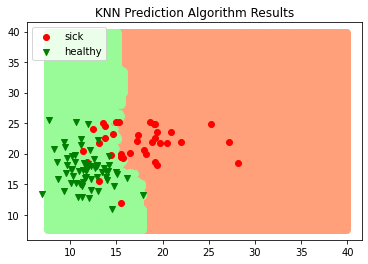

In [22]:
# Task 5: visualization
# plotting is done by combining the training and validating sick and healthy data
# into two respective arrays because using more markers made it not properly visible

def visualization(data_set_1, label1, data_set_2, label2, title):
    plt.title(title)
    
    # background
    plt.scatter(array_sick_v[:, 0].reshape(-1,), array_sick_v[:, 1].reshape(-1,), marker="H", c="lightsalmon")
    plt.scatter(array_healthy_v[:, 0].reshape(-1,), array_healthy_v[:, 1].reshape(-1,), marker="H", c="palegreen")
    #plt.savefig('backgroundimage')
    
    # actual points
    array_sick = np.concatenate([data_set_1[np.where(label1==1)], data_set_2[np.where(label2==1)]])
    array_healthy = np.concatenate([data_set_1[np.where(label1==0)],data_set_2[np.where(label2==0)]])
    plt.scatter(array_sick[:, 0].reshape(-1,), array_sick[:, 1].reshape(-1,), marker="o", label="sick", c="r")
    plt.scatter(array_healthy[:, 0].reshape(-1,), array_healthy[:, 1].reshape(-1,), marker="v", label="healthy", c="g")
    plt.legend()
    plt.show()



visualization(training_set[0:60], training_label[0:60], validation_set[0:40], validation_label[0:40], "KNN Prediction Algorithm Results")  